In [1]:
from transformers import AlbertTokenizer, AlbertModel
import torch

import pandas as pd
from pandas import Series, DataFrame

import numpy as np
import tqdm

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import joblib

import os

/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '

In [2]:
MOVIE_FREQ_CO = 1
SERIAL_FREQ_CO = 1
DIR = 'movies_encoded_v1'

In [3]:

for i in os.listdir(DIR):
    os.remove(DIR + '/' + i)
os.removedirs(DIR)

os.mkdir(DIR)

In [4]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertModel.from_pretrained('albert-base-v2', return_dict=True).cuda()

In [5]:
movies = pd.read_csv('movies/movies.csv')

In [6]:
movies['description']

0        A brilliant and neurotic attorney goes to Mona...
1        Jack is encouraged to take the romantic Paris ...
2        A vain London playboy offers his soul in excha...
3        A British writer struggles to fit in at a high...
4        The story of two men on different sides of a p...
                               ...                        
19260    Two feuding detectives hunt down a cop-killer ...
19261    Preschool kids whose parents are the world's m...
19262                                                  NaN
19263    A gang of thieves plan a heist during a hurric...
19264    Milo works as a bartender in Berlin and one ni...
Name: description, Length: 19265, dtype: object

In [7]:
data = pd.read_csv('movies/movies_dataset_10 months.csv')

In [8]:
film_freq = data['movie_id'].value_counts()

In [9]:
film_freq

12304    6375
7735     4630
15285    4360
17518    3465
19026    1718
         ... 
19242       1
18660       1
19355       1
18218       1
19828       1
Name: movie_id, Length: 4843, dtype: int64

In [10]:
ep_freq = data['episode_id'].value_counts()

In [11]:
ep_freq

0         217829
118480       258
110439       244
117588       243
114421       204
           ...  
108261         1
92772          1
122602         1
125300         1
79833          1
Name: episode_id, Length: 13302, dtype: int64

In [12]:
serial_flg = data.groupby('movie_id')['episode_id'].max() > 0

In [13]:
serial_flg

movie_id
0         True
1        False
2        False
3        False
4        False
         ...  
20249    False
20287     True
20324    False
20325    False
20326    False
Name: episode_id, Length: 4843, dtype: bool

In [14]:
movies['is_serial'] = movies['id'].map(serial_flg).fillna(False).astype(bool).values

In [15]:
movies['is_serial'].isnull().sum()

0

In [16]:
movies['freq'] = movies['id'].map(film_freq).fillna(0).values

In [17]:
sl = (~movies['is_serial'] & movies['freq'] >= MOVIE_FREQ_CO) | (movies['is_serial'] & movies['freq'] >= SERIAL_FREQ_CO)

In [18]:
movies = movies[sl].reset_index(drop=True)

In [19]:
data['ts'].astype(np.datetime64).sort_values()

0        2019-10-01 00:01:31
1        2019-10-01 00:01:38
2        2019-10-01 00:01:57
3        2019-10-01 00:02:41
4        2019-10-01 00:03:17
                 ...        
346403   2020-07-31 23:57:10
346404   2020-07-31 23:57:31
346405   2020-07-31 23:57:49
346406   2020-07-31 23:57:57
346407   2020-07-31 23:57:57
Name: ts, Length: 346408, dtype: datetime64[ns]

In [20]:
movies.shape

(4407, 18)

In [21]:
movies['emb_idx'] = np.arange(movies.shape[0])

In [22]:
def get_bert_embedding(ser):
    
    batch = ser.fillna('').tolist()
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
    inputs = {x: inputs[x].cuda() for x in inputs}
    outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
    
    return last_hidden
    
    

In [23]:

text_batches = np.array_split(movies['description'], movies.shape[0] // 16)
preds = [get_bert_embedding(x) for x in tqdm.tqdm_notebook(text_batches)]
# preds = preds + [np.zeros((1, 768), dtype=np.float32)]

text_embeddings = np.concatenate(preds, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [24]:
joblib.dump(text_embeddings, DIR + '/descr_embeddings.pkl')

['movies_encoded_v1/descr_embeddings.pkl']

In [25]:
def get_top(un, top):
    
    res = []
    
    for x in un:
        if x in top:
            res.append(top[x])
            
    return res

def get_encoded_repr(ser, top_n = 5, min_freq = 1):
    
    ser = ser.fillna('').str.replace(' ', '').str.split(',')
    ser = ser.map(lambda x: x[:top_n])
    
    uniques = []
    [uniques.extend(x) for x in ser]
    cnt = Series(Counter(uniques))
    uniques = cnt[cnt >= min_freq].index.values
    
    uniques = Series(np.arange(len(uniques)), index=uniques)
    
    col = ser.map(lambda x: get_top(x, uniques))
    
    return uniques, col
    
    

In [26]:
uniques, col = get_encoded_repr(movies['genres'], top_n = 5, min_freq = 1)

In [27]:
col

0            [0, 1]
1            [0, 2]
2            [3, 4]
3            [0, 1]
4            [5, 3]
           ...     
4402         [0, 1]
4403      [5, 9, 4]
4404    [14, 15, 6]
4405           [18]
4406           [18]
Name: genres, Length: 4407, dtype: object

In [28]:
(movies['director'].fillna('').map(lambda x: ',' in x)).sum()

164

In [29]:
movies['people'] = ''

for i in ['director', 'actors', 'writers', 'music', 'art', 'producer']:
    movies['people'] = movies['people'] + movies[i].fillna('').map(lambda x: x if x == '' else x + ',')

movies['people'] = movies['people'].map(lambda x: '' if x == '' else x[:-1])

In [30]:
movies.columns

Index(['id', 'year', 'title', 'description', 'genres', 'director', 'actors',
       'writers', 'music', 'art', 'producer', 'imdb_id', 'tmdb_id',
       'imdb_rating', 'tmdb_rating', 'available_now', 'is_serial', 'freq',
       'emb_idx', 'people'],
      dtype='object')

In [31]:
for i in ['genres', 'director', 'actors', 'writers', 'music', 'art', 'producer']:
    uniques, col = get_encoded_repr(movies[i], top_n = 3, min_freq = 3)
    movies[i] = col

In [32]:
uniques, col = get_encoded_repr(movies['people'], top_n = 100000000, min_freq = 3)

movies['people'] = col

In [33]:
# movies.drop(#['title', 'description',], 
#             axis=1, inplace=True)
movies['available_now'] = movies['available_now'] == 'yes'

movies['year'] = 2020 - movies['year']
movies['year'] = np.log(movies['year'] + 1)
movies['year'] = movies['year'].fillna(movies['year'].mean())

movies['freq'] = np.log(movies['freq'])

for i in ['imdb_rating', 'tmdb_rating', 'year', 'freq']:
    movies[i] = (movies[i] - movies[i].mean()) / movies[i].std()
    

In [34]:
movies['year'].max()

2.3077427103044

In [35]:
%matplotlib inline

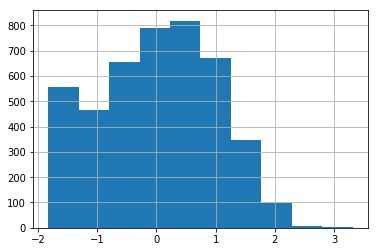

In [36]:
movies['freq'].hist()

In [37]:
movies['freq'].mean()

1.2898438588792379e-17

In [38]:
movies

id      year                                  title  \
0         1  0.296135                   The Girl from Monaco   
1         2  0.296135                  Every Jack has a Jill   
2         3  0.208711                            Dorian Gray   
3         4  0.296135  How to Lose Friends & Alienate People   
4         5  0.208711                               Cell 211   
...     ...       ...                                    ...   
4402  20245 -0.379989                   She's Funny That Way   
4403  20249 -1.305420                Solo: A Star Wars Story   
4404  20324 -0.991209                                    Zoo   
4405  20325 -0.548354                            Phantom Boy   
4406  20326 -0.747488                         The Red Turtle   

                                            description       genres director  \
0     A brilliant and neurotic attorney goes to Mona...       [0, 1]      [0]   
1     Jack is encouraged to take the romantic Paris ...       [0, 2]       []   
2     A vain London playboy offers his soul in excha...       [3, 4]      [1]   
3     A British writer struggles to fit in at a high...       [0, 1]       []   
4     The story of two men on different sides of a p...       [5, 3]       []   
...                                                 ...          ...      ...   
4402  On the set of a playwright's new project, a lo...       [0, 1]       []   
4403  Through a series of daring escapades deep with...    [5, 9, 4]    [149]   
4404  Young Tom and his misfit friends fight to save...  [12, 13, 6]       []   
4405  At a hospital in New York, Alex, a police offi...         [17]       []   
4406  The dialogue-less film follows the major life ...         [17]       []   

                actors writers music     art   producer    imdb_id   tmdb_id  \
0                  [0]  [0, 1]   [0]     [0]  [0, 1, 2]  tt1139800   15342.0   
1               [1, 2]      []   [1]     [1]        [3]  tt1094668   32338.0   
2               [3, 4]      []    []     [2]        [4]  tt1235124   23488.0   
3            [5, 6, 7]      []    []  [2, 3]  [5, 6, 7]  tt0455538   13092.0   
4                   []      []   [2]      []        [8]  tt1242422   33273.0   
...                ...     ...   ...     ...        ...        ...       ...   
4402  [597, 1166, 146]      []  [47]    [26]      [143]  tt1767372  245906.0   
4403             [334]      []  [93]      []         []  tt3778644  348350.0   
4404             [314]     [3]   [1]     [0]       [18]  tt3688342  472553.0   
4405         [9, 1255]     [3]   [1]     [0]       [18]  tt1856057  356161.0   
4406                []     [3]  [86]     [0]         []  tt3666024  337703.0   

      imdb_rating  tmdb_rating  available_now  is_serial      freq  emb_idx  \
0       -0.621232    -0.808802           True      False  0.062896        0   
1       -0.350945    -0.433055           True      False -0.130027        1   
2       -0.170753    -0.119932           True      False  0.546917        2   
3       -0.080658     0.005317           True      False  0.293135        3   
4        1.000492     0.819435           True      False  1.597460        4   
...           ...          ...            ...        ...       ...      ...   
4402    -0.350945    -0.119932          False      False -0.537098     4402   
4403     0.369821     0.318439          False      False  0.834419     4403   
4404     0.009438     0.193190           True      False -1.420411     4404   
4405     0.099534     0.631562           True      False -1.182290     4405   
4406     0.910396     0.944684           True      False -1.013340     4406   

                                                 people  
0                     [0, 1, 2, 3, 4, 0, 5, 6, 7, 8, 9]  
1                          [10, 11, 12, 13, 14, 15, 16]  
2      [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]  
3              [29, 30, 31, 32, 33, 27, 34, 35, 36, 37]  
4                                      [38, 39, 40, 41]  
...      

In [39]:
joblib.dump(movies, DIR + '/movies.pkl')

['movies_encoded_v1/movies.pkl']

In [40]:
cnt = CountVectorizer()

In [41]:
enc = cnt.fit_transform(movies['title'].fillna('')).toarray()

In [42]:
pairw = np.dot(enc, enc.T)

In [43]:
pairw.shape

(4407, 4407)

In [44]:
joblib.dump(pairw, DIR + '/names_dist.pkl')

['movies_encoded_v1/names_dist.pkl']